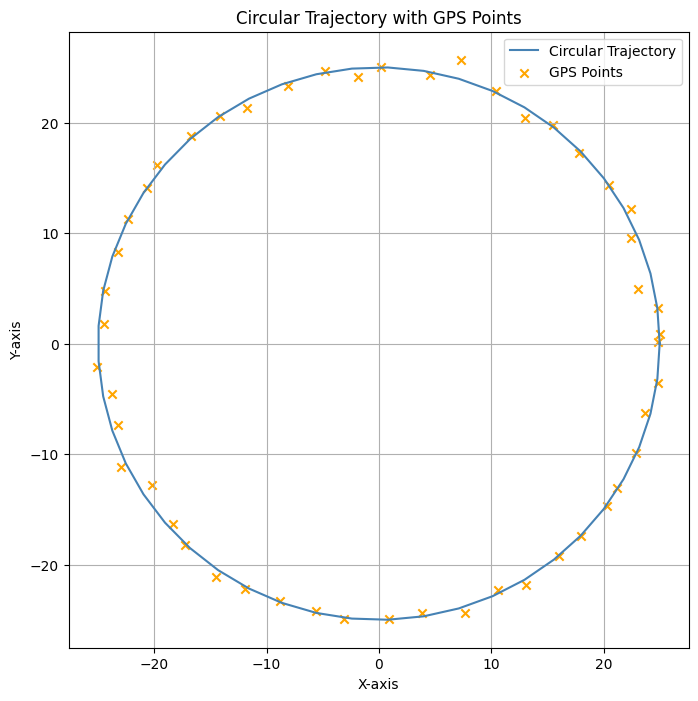

In [1]:
import numpy as np
import matplotlib.pyplot as plt

nbr_sample_GPS = 50
# Generate time values for one turn (1 second)
time_values = np.linspace(0, 1, nbr_sample_GPS)

# Define the circular trajectory using sine and cosine functions
radius = 25
x_ref = radius * np.cos(2 * np.pi * time_values)
y_ref = radius * np.sin(2 * np.pi * time_values)

#white noise GPS
sigma_x_gps = 0.5
sigma_y_gps = 0.5

noise_x_GPS = sigma_x_gps*np.random.randn(nbr_sample_GPS)
noise_y_GPS = sigma_y_gps*np.random.randn(nbr_sample_GPS)

x_GPS = noise_x_GPS + x_ref
y_GPS = noise_y_GPS + y_ref

# Plot the circular trajectory and GPS points
plt.figure(figsize=(8, 8))
plt.plot(x_ref, y_ref, label='Circular Trajectory', color='steelblue')
plt.scatter(x_GPS, y_GPS, c='orange', marker='x', label='GPS Points')
plt.title('Circular Trajectory with GPS Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
def change_frame(accel_body,orientation):
    R = np.array([[np.cos(orientation), -np.sin(orientation)],
                  [np.sin(orientation), np.cos(orientation)]])
    accel_local = R.dot(accel_body)
    return accel_local
    

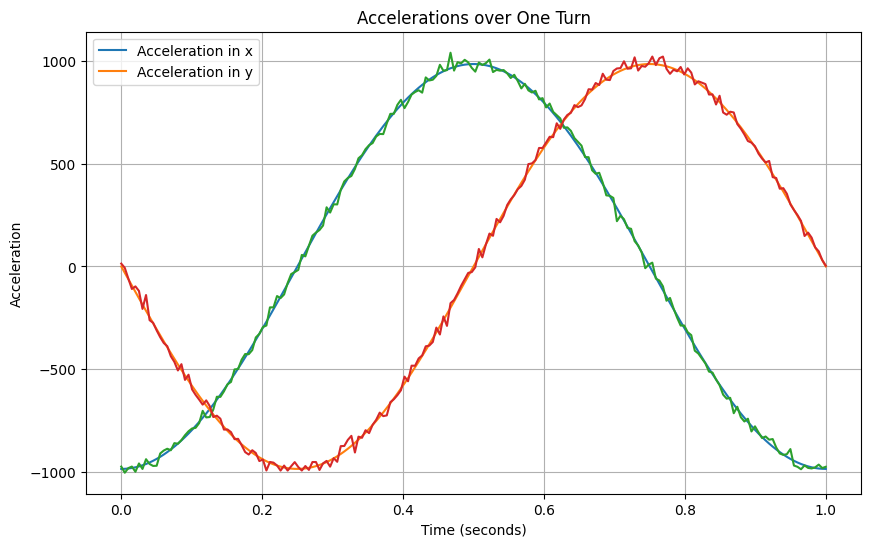

In [3]:
# Function to calculate ax and ay values
def calculate_accelerations(t):
    a_x = -4*np.pi*np.pi *radius* np.cos(2 * np.pi * t)
    a_y = -4*np.pi*np.pi *radius*np.sin(2 * np.pi * t)
    return a_x, a_y

nbr_sample_acc = 200
# Generate time values for one turn (1 second)
time_values = np.linspace(0, 1, 200)

# Calculate accelerations for each time value
accelerations = np.array([calculate_accelerations(t) for t in time_values])

# Separate ax and ay values
a_x_values = accelerations[:, 0]
a_y_values = accelerations[:, 1]

sigma_white_noise= 20

noise_ax = sigma_white_noise*np.random.randn(nbr_sample_acc)
noise_ay = sigma_white_noise*np.random.randn(nbr_sample_acc)

ax_noisy = noise_ax + a_x_values
ay_noisy = noise_ay + a_y_values
# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(time_values, a_x_values, label='Acceleration in x')
plt.plot(time_values, a_y_values, label='Acceleration in y')
plt.plot(time_values,ax_noisy)
plt.plot(time_values,ay_noisy)
plt.title('Accelerations over One Turn')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()

#for the next steps we will use those names for acceleration components
accel_rw_x = ax_noisy
accel_rw_y = ay_noisy

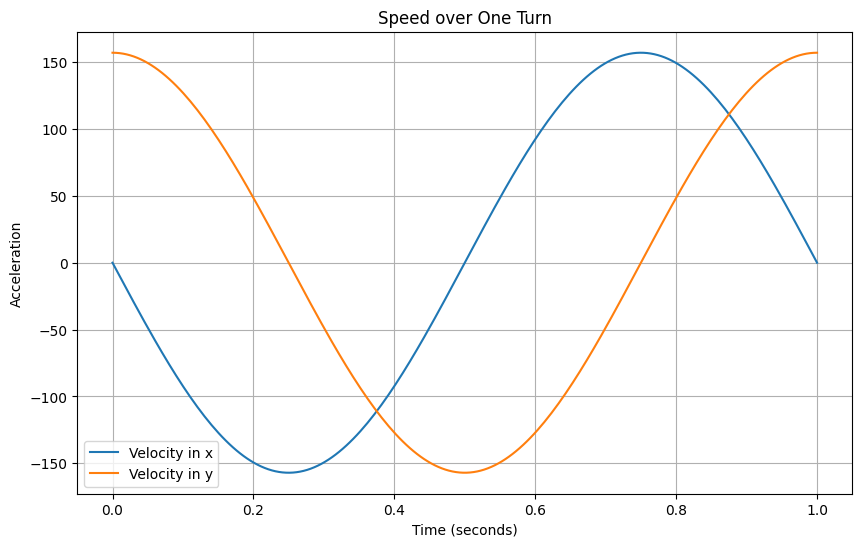

157.07963267948966


In [11]:
def calculate_speed(t):
    vx = -2*np.pi *radius* np.sin(2 * np.pi * t)
    vy = 2*np.pi *radius*np.cos(2 * np.pi * t)
    return vx, vy

nbr_sample_acc = 200
# Generate time values for one turn (1 second)
time_values = np.linspace(0, 1, 200)

# Calculate accelerations for each time value
speed = np.array([calculate_speed(t) for t in time_values])

# Separate ax and ay values
vx_values = speed[:, 0]
vy_values = speed[:, 1]

sigma_white_noise= 50

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(time_values, vx_values, label='Velocity in x')
plt.plot(time_values, vy_values, label='Velocity in y')
plt.title('Speed over One Turn')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()
print(vy_values[0])

In [5]:

# Generate timestamps for 200 Hz and 100 Hz arrays
timestamps_acc = np.arange(len(accel_rw_x))   # Timestamps for accelerometer
timestamps_acc = timestamps_acc/timestamps_acc[-1]
timestamps_gps = np.arange(len(x_GPS))   # Timestamps for GPS
timestamps_gps = timestamps_gps/timestamps_gps[-1]
sigma_timestamps = 0.0001

# Add small noise to the timestamps
noise_acc = np.random.normal(0, sigma_timestamps, len(timestamps_acc)) # Adjust the standard deviation as needed
timestamps_acc_y = timestamps_acc + noise_acc
noise_acc = np.random.normal(0, sigma_timestamps, len(timestamps_acc))
timestamps_acc_x = timestamps_acc + noise_acc
noise_gps = np.random.normal(0, sigma_timestamps, len(timestamps_gps))
timestamps_gps_x = timestamps_gps + noise_gps
noise_gps = np.random.normal(0, sigma_timestamps, len(timestamps_gps))
timestamps_gps_y = timestamps_gps + noise_gps

timestamps_acc_y = np.sort(timestamps_acc_y)
timestamps_acc_x = np.sort(timestamps_acc_x)
timestamps_gps_x = np.sort(timestamps_gps_x)
timestamps_gps_y = np.sort(timestamps_gps_y)


timestamps_gps_x = np.concatenate((timestamps_gps_x[:20], timestamps_gps_x[30+1:]))
timestamps_gps_y = np.concatenate((timestamps_gps_y[:20], timestamps_gps_y[30+1:]))

x_GPS = np.concatenate((x_GPS[:20], x_GPS[30+1:]))
y_GPS  = np.concatenate((y_GPS[:20], y_GPS[30+1:]))

timestamps_copy_x = timestamps_gps_x
timestamps_copy_y = timestamps_gps_y


In [6]:
from filterpy.kalman import KalmanFilter

kf = KalmanFilter(dim_x=6, dim_z=1)

kf.F = np.array([[1, 0, 1, 0,1,0],
            [0,1,0,1,0,1],
            [0,0,1,0,1,0],
            [0,0,0,1,0,1],
            [0,0,0,0,1,0],
            [0,0,0,0,0,1]])

kf.H = np.array([[1,0,0,0],
                 [0,1,0,0],
                 [0,0,0,0],
                 [0,0,0,0],
                 [0,0,1,0],
                 [0,0,0,1]])


kf.x = np.array([x_GPS[0],y_GPS[0],vx_values[0],vy_values[0],accel_rw_x[0],accel_rw_y[0]])

kf.P = 100*np.eye(6)
x_GPS_copy = x_GPS
y_GPS_copy = y_GPS
accel_rw_x_copy = accel_rw_x
accel_rw_y_copy = accel_rw_y

accel_rw_x_copy = accel_rw_x_copy[1:]
accel_rw_y_copy = accel_rw_y_copy[1:]
x_GPS_copy = x_GPS_copy[1:]
y_GPS_copy = y_GPS_copy[1:]

timestamps_acc_x = timestamps_acc_x[1:]
timestamps_acc_y = timestamps_acc_y[1:]
timestamps_gps_x = timestamps_gps_x[1:]
timestamps_gps_y = timestamps_gps_y[1:]

xs, ts = [],  []
last_t = 0
compteur = 0

while len(accel_rw_y_copy) > 0 and len(accel_rw_x_copy) > 0 and len(x_GPS_copy)>0 and len(y_GPS_copy)>0:
    if timestamps_acc_x[0]<timestamps_acc_y[0] and timestamps_acc_x[0]<timestamps_gps_x[0] and timestamps_acc_x[0]<timestamps_gps_y[0]:
        z = accel_rw_x_copy[0]
        accel_rw_x_copy = accel_rw_x_copy[1:]
        t = timestamps_acc_x[0]
        timestamps_acc_x = timestamps_acc_x[1:]
        dt = t - last_t
        last_t = t

        kf.H = np.array([[0,0,0,0,1,0]])
        kf.R[0,0] = sigma_white_noise**2
    elif timestamps_acc_y[0]<timestamps_gps_x[0] and timestamps_acc_y[0]<timestamps_gps_y[0]:
        z = accel_rw_y_copy[0]
        accel_rw_y_copy = accel_rw_y_copy[1:]
        t = timestamps_acc_y[0]
        timestamps_acc_y = timestamps_acc_y[1:]
        dt = t - last_t
        last_t = t

        kf.H = np.array([[0,0,0,0,0,1]])
        kf.R[0,0] = sigma_white_noise**2

    elif timestamps_gps_x[0]<timestamps_gps_y[0]:
        z = x_GPS_copy[0]
        x_GPS_copy = x_GPS_copy[1:]
        t = timestamps_gps_x[0]
        timestamps_gps_x = timestamps_gps_x[1:]
        dt = t - last_t
        last_t = t

        kf.H = np.array([[1,0,0,0,0,0]])
        kf.R[0,0] = sigma_x_gps**2
    else:
        z = y_GPS_copy[0]
        y_GPS_copy = y_GPS_copy[1:]
        t = timestamps_gps_y[0]
        timestamps_gps_y = timestamps_gps_y[1:]
        dt = t - last_t
        last_t = t

        kf.H = np.array([[0,1,0,0,0,0]])
        kf.R[0,0] = sigma_y_gps**2
        
    kf.F = np.array([[1,0,dt,0,0.5*dt**2,0],
                     [0,1,0,dt,0,0.5*dt**2],
                     [0,0,1,0,dt,0],
                     [0,0,0,1,0,dt],
                     [0,0,0,0,1,0],
                     [0,0,0,0,0,1]])
    
    #process noise matrix (very generic)
    sigma_acc = sigma_white_noise
    
    kf.Q = np.array([
        [1/4 * sigma_acc**2 * dt**4, 0, 0, 0, 0, 0],
        [0, 1/4 * sigma_acc**2 * dt**4, 0, 0, 0, 0],
        [0, 0, sigma_acc**2 * dt**2, 0, 0, 0],
        [0, 0, 0, sigma_acc**2 * dt**2, 0, 0],
        [0, 0, 0, 0, sigma_acc**2, 0],
        [0, 0, 0, 0, 0, sigma_acc**2]])
    
    kf.predict()
    kf.update(np.array([z]))
    xs.append(kf.x.T)
    ts.append(t)


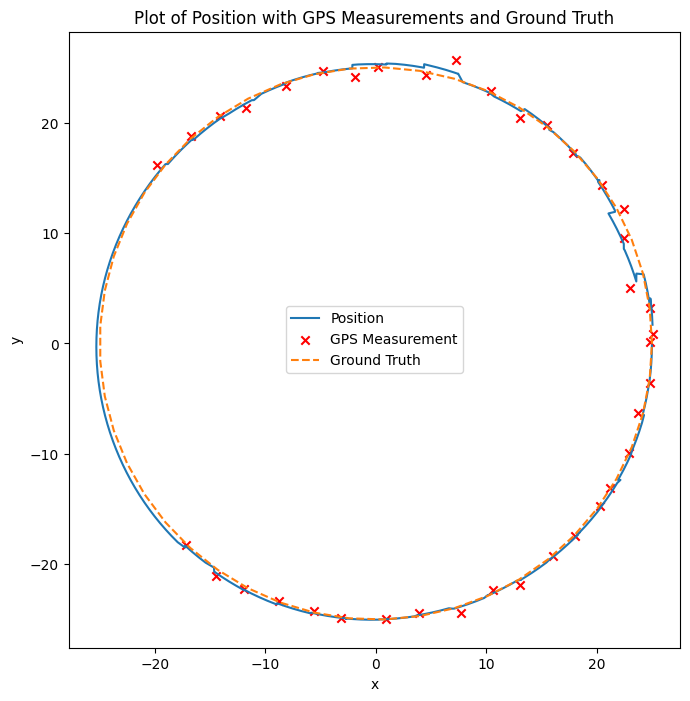

In [7]:
# Extracting individual columns
xs = np.array(xs)
posx = xs[:, 0]
posy = xs[:, 1]

# Plotting positions
plt.figure(figsize=(8, 8))
plt.plot(posx, posy, label='Position')

# Plotting GPS measurements
plt.scatter(x_GPS, y_GPS, marker='x', color='red', label='GPS Measurement')

# Plotting ground truth
plt.plot(x_ref, y_ref, '--', label='Ground Truth')

plt.title('Plot of Position with GPS Measurements and Ground Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

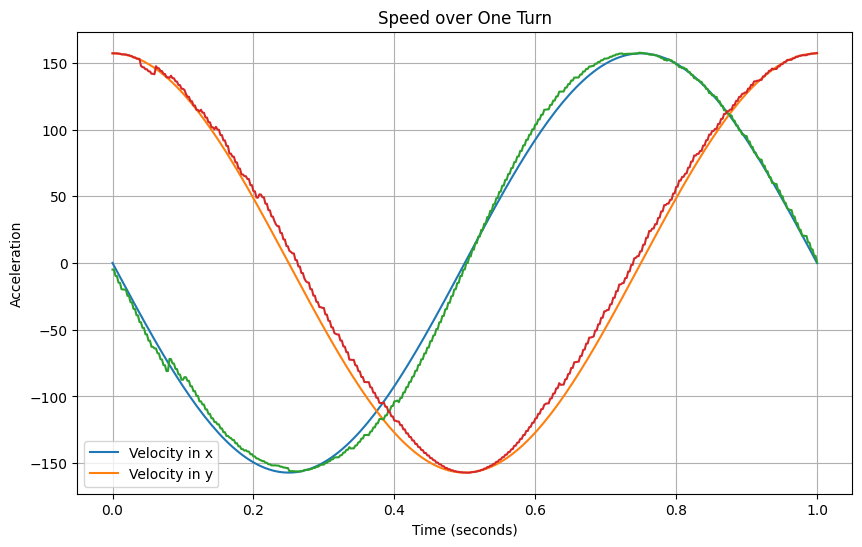

In [8]:
velx = xs[:,2]
vely = xs[:,3]

# Plot the graph
plt.figure(figsize=(10, 6))
time_values = np.linspace(0, 1, np.size(vx_values))
plt.plot(time_values, vx_values, label='Velocity in x')
plt.plot(time_values, vy_values, label='Velocity in y')
time_values = np.linspace(0, 1, np.size(velx))
plt.plot(time_values,velx)
plt.plot(time_values,vely)
plt.title('Speed over One Turn')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()



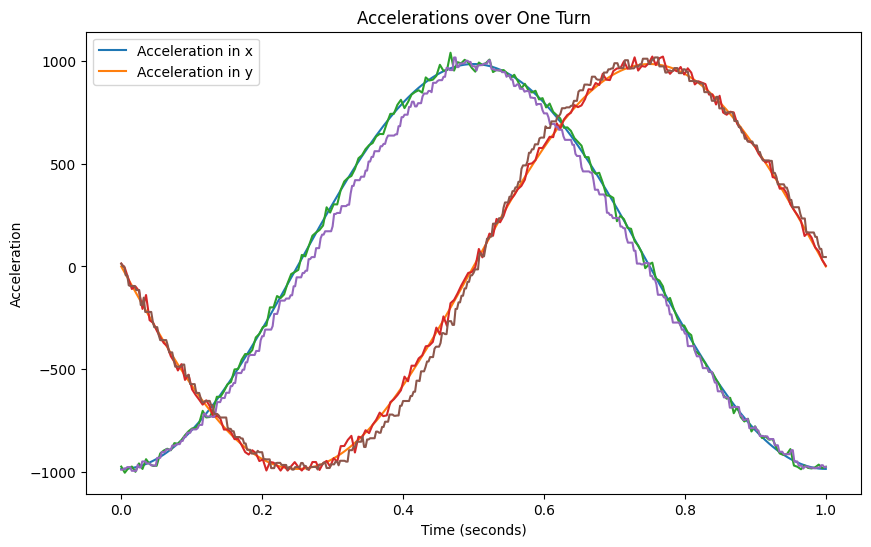

In [9]:
accx = xs[:, 4]
accy = xs[:, 5]

# Generate time values for one turn (1 second)


# Plot the graph
plt.figure(figsize=(10, 6))
time_values = np.linspace(0, 1, np.size(a_x_values))
plt.plot(time_values, a_x_values, label='Acceleration in x')
plt.plot(time_values, a_y_values, label='Acceleration in y')
plt.plot(time_values,ax_noisy)
plt.plot(time_values,ay_noisy)
time_values = np.linspace(0, 1, np.size(accx))
plt.plot(time_values,accx)
plt.plot(time_values,accy)

plt.title('Accelerations over One Turn')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration')
plt.legend()
plt.show()


In [10]:
from filterpy.kalman import KalmanFilter

tracker = KalmanFilter(dim_x = 4, dim_z = 4)
dt = delta_t
tracker.F = np.array([[1, 0,(dt**2)/2 , 0],
                      [0,1,0,(dt**2)/2],
                      [0,0,1,0],
                      [0,0,0,1]])

NameError: name 'delta_t' is not defined

In [ ]:
#process noise matrix (very generic)
q_x = 0.01
q_y = 0.01
q_dot_x = 0.01
q_dot_y = 0.01
q_xy = 0.  # covariance between position and accelcomponents

# Create the process noise matrix
Q = np.array([
        [q_x, 0, q_xy, 0],
        [0, q_y, 0, q_xy],
        [q_xy, 0, q_dot_x, 0],
        [0, q_xy, 0, q_dot_y]
    ])

tracker.Q = Q
print(tracker.Q)

#### CARE Q MATRIX IS NOT RIGHT !!!!!!####

[[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]


In [ ]:
#z = H*X
tracker.H = np.array([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,0],
                      [0,0,0,0]])

In [ ]:
#Measurement noise
tracker.R = np.array([[sigma_x_gps**2, 0,0,0],
                      [0, sigma_y_gps**2,0,0],
                      [0,0,sigma_white_noise**2,0],
                      [0,0,0,sigma_white_noise**2]])

In [ ]:
#original position
tracker.x = np.array([[0, 24.682, 0, -2.46740110e-02]]).T
tracker.P = np.eye(4) * 1

In [ ]:
#zs = measurement
nbr_samples = len(x_GPS)

# Create an array of shape (nbr_samples, 4)
combined_array = np.zeros((nbr_samples, 4))
# Assign values to the columns
combined_array[:, 0] = x_GPS
combined_array[:, 1] = y_GPS
combined_array[:, 2] = accel_rw_x
combined_array[:, 3] = accel_rw_y


zs = combined_array

ValueError: could not broadcast input array from shape (200,) into shape (39,)

In [ ]:
mu, cov, _, _ = tracker.batch_filter(zs)

In [ ]:
mu = np.squeeze(mu, axis=2)

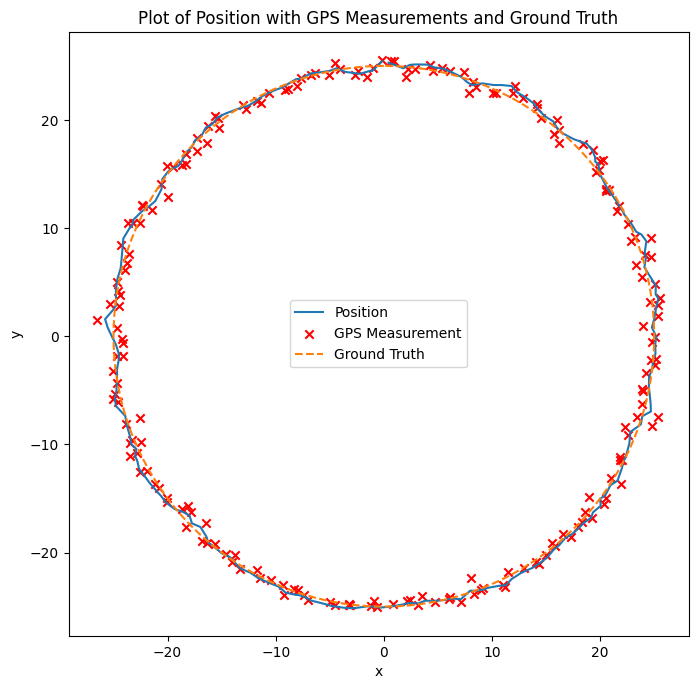

In [ ]:

# Extracting individual columns
posx = mu[:, 0]
posy = mu[:, 1]

# Plotting positions
plt.figure(figsize=(8, 8))
plt.plot(posx, posy, label='Position')

# Plotting GPS measurements
plt.scatter(x_GPS, y_GPS, marker='x', color='red', label='GPS Measurement')

# Plotting ground truth
plt.plot(x_ref, y_ref, '--', label='Ground Truth')

plt.title('Plot of Position with GPS Measurements and Ground Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [ ]:
#delete every 5 measurement
for i in range(len(x_GPS)):
    if i%5 !=0 and i !=0:
        x_GPS[i] = None
        y_GPS[i] = None 

In [ ]:
#Kalman filter but not same rate
 
kf = KalmanFilter(dim_x=4, dim_z=4)
kf.F = tracker.F
kf.H = tracker.H
kf.x = tracker.x
kf.P = tracker.P

hist_pos = []
offset = 0
for i in range(len(x_GPS)):
    if x_GPS[i] == None:
        offset = i%5
        kf.H = np.array([[0,0,0,0],
                      [0,0,0,0],
                      [0,0,0,0],
                      [0,0,0,0]])
        kf.R = np.array([[0, 0,0,0],
                      [0, 0,0,0],
                      [0,0,sigma_white_noise**2,0],
                      [0,0,0,sigma_white_noise**2]])
        kf.predict()
        kf.update(np.array([0,0,accel_rw_x[i],accel_rw_y[i]]))
        hist_pos.append(kf.x)
     
    else:
        kf.H = tracker.H
        kf.R = tracker.R
        kf.predict()
        kf.update(np.array([x_GPS[i],y_GPS[i],accel_rw_x[i],accel_rw_y[i]]))
        hist_pos.append(kf.x)
       
hist_pos = np.array(hist_pos)
    

In [ ]:
print(np.shape(hist_pos))
mu = np.squeeze(hist_pos, axis=2)
print(hist_pos)

(201, 4, 1)
[[[-0.20097482]
  [25.5588562 ]
  [-1.40742517]
  [ 0.28220121]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

 [[        nan]
  [        nan]
  [        nan]
  [        nan]]

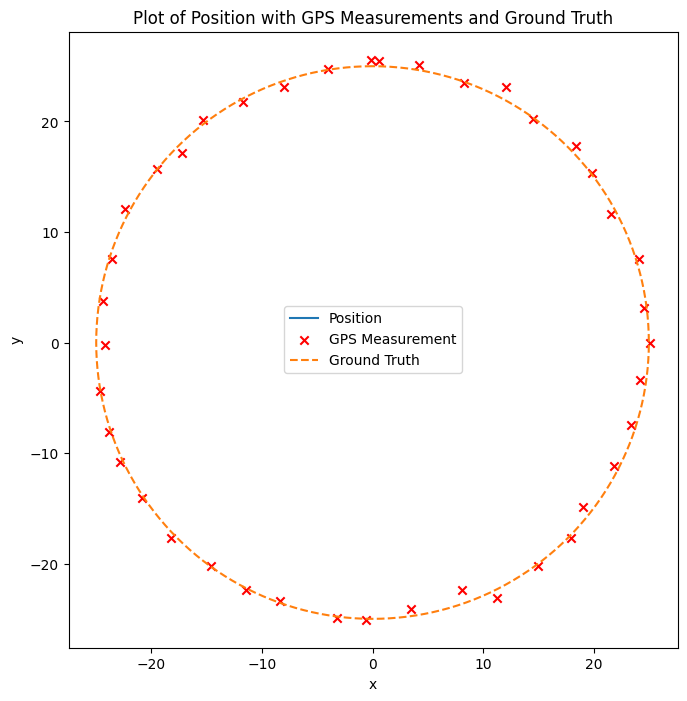

In [ ]:
# Extracting individual columns
posx = hist_pos[:, 0]
posy = hist_pos[:, 1]

# Plotting positions
plt.figure(figsize=(8, 8))
plt.plot(posx, posy, label='Position')

# Plotting GPS measurements
plt.scatter(x_GPS, y_GPS, marker='x', color='red', label='GPS Measurement')

# Plotting ground truth
plt.plot(x_ref, y_ref, '--', label='Ground Truth')

plt.title('Plot of Position with GPS Measurements and Ground Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()